# Explore Double Descent with MNIST

Ref Article:
- https://medium.com/mlearning-ai/double-descent-8f92dfdc442f
- https://evjang.com/2021/10/23/generalization.html

# Use Weight and Bias as Dashboard with pytorch lightning

In [1]:
# Some Hyperparameter Defination
BATCH_SIZE = 1024

## MNIST dataset

In [2]:
import os
from typing import Optional

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import functional as F
from torch import nn
from torch.utils.data import DataLoader, random_split

from torchvision.datasets import MNIST
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.metrics.functional import accuracy

MNIST.mirrors = [mirror for mirror in MNIST.mirrors
                 if not mirror.startswith("http://yann.lecun.com")]

In [3]:
# pl dataMoudle ref: 
# https://pytorch-lightning.readthedocs.io/en/latest/extensions/datamodules.html

class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = "./data", batch_size: int = 1024):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        
    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage: Optional[str] = None):
        self.mnist_test = MNIST(self.data_dir, train=False, transform=transforms.ToTensor())
        mnist_full = MNIST(self.data_dir, train=True, transform=transforms.ToTensor())
        self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size)

In [4]:
dm = MNISTDataModule()
dm.prepare_data()
dm.setup()

## Quick look at the training set

Feature batch shape: torch.Size([1024, 1, 28, 28])
Labels batch shape: torch.Size([1024])


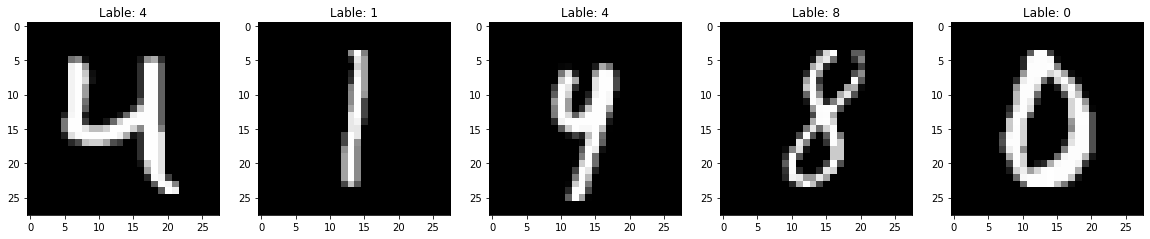

In [13]:
# Display image and label.
train_features, train_labels = next(iter(dm.train_dataloader()))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

images=[]

for i in range(0, 5):
    images.append(train_features[i].squeeze())

plt.figure(figsize=(20,10))
columns = 5

for i, image in enumerate(images):
    ax = plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    ax.imshow(image, cmap="gray")
    ax.title.set_text("Lable: {}".format(train_labels[i]))